# Example 10.15
Apply Runge-Kutta method to find an approximate value of y when x = 0.2, given that dy/dx = x + y and y = 1 when x = 0.

Adam Iter 0, Loss 1.352e+00
Adam Iter 1000, Loss 2.954e-04
Adam Iter 2000, Loss 8.141e-06
Adam Iter 3000, Loss 5.903e-06
Adam Iter 4000, Loss 4.933e-06
Adam Iter 5000, Loss 4.519e-04
Adam Iter 6000, Loss 3.872e-06
Adam Iter 7000, Loss 3.260e-06
Adam Iter 8000, Loss 5.247e-06
Adam Iter 9000, Loss 2.367e-06
x=0.0, Exact=1.000000, RK4=1.000000, PINN=0.999992
x=0.2, Exact=1.242806, RK4=1.242800, PINN=1.242777
x=0.4, Exact=1.583649, RK4=1.583636, PINN=1.583515
x=0.6, Exact=2.044238, RK4=2.044213, PINN=2.044301
x=0.8, Exact=2.651082, RK4=2.651042, PINN=2.650987
x=1.0, Exact=3.436564, RK4=3.436502, PINN=3.436528


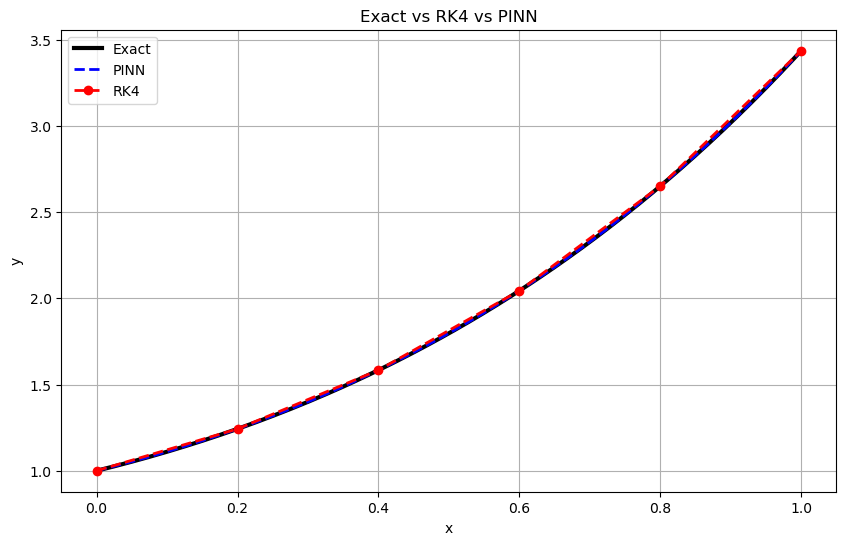

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# ====================================
# 1. Exact Solution
# ====================================
x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(sp.diff(y, x, 1), x + y)
sol = sp.dsolve(ode, y, ics={y.subs(x, 0): 1})
exact_numc = sp.lambdify(x, sol.rhs, 'numpy')
x_vals = np.linspace(0, 1, 6)
exact_sol = exact_numc(x_vals)

# ====================================
# 2. RK4 Method
# ====================================
def f(x, y):
    return x + y

def runge_kutta(f, x0, y0, n, h):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0
    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = runge_kutta(f, 0, 1, 5, 0.2)

# ===================================
# 3. PINN
# ===================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)

def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f = dy - y - x_colloc
    loss_pde = torch.mean(f**2)

    y0 = model(x0)
    loss_bc = torch.mean((y0 - 1)**2)
    return loss_pde + loss_bc

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 1, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, exact_sol, ys, y_pinn):
    print(f'x={xi:.1f}, Exact={yi:.6f}, RK4={zi:.6f}, PINN={pi:.6f}')

# ===================================
# 4. Plot
# ===================================
x_plot = np.linspace(0, 1, 200)
x_pinn_plot = torch.tensor(x_plot, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(x_plot, exact_numc(x_plot), 'k-', label='Exact', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'b--', label='PINN', linewidth=2)
plt.plot(xs, ys, 'r--o', label='RK4', linewidth=2)
plt.title('Exact vs RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Example 10.16
Using the Runge-Kutta method of fourth order, solve $dy/dx = (y^2 - x^2)/(y^2 + x^2)$ with $y(0) = 1$ at $x = 0.2, 0.4$.

Adam Iter 0 Loss 1.891e+00
Adam Iter 1000 Loss 3.640e-05
Adam Iter 2000 Loss 2.892e-05
Adam Iter 3000 Loss 2.034e-05
Adam Iter 4000 Loss 1.099e-05
Adam Iter 5000 Loss 4.197e-06
Adam Iter 6000 Loss 2.604e-06
Adam Iter 7000 Loss 1.928e-06
Adam Iter 8000 Loss 1.508e-05
Adam Iter 9000 Loss 6.702e-07
x=0.0, RK4=1.000000, PINN=1.000002
x=0.2, RK4=1.196000, PINN=1.195933
x=0.4, RK4=1.375267, PINN=1.375305


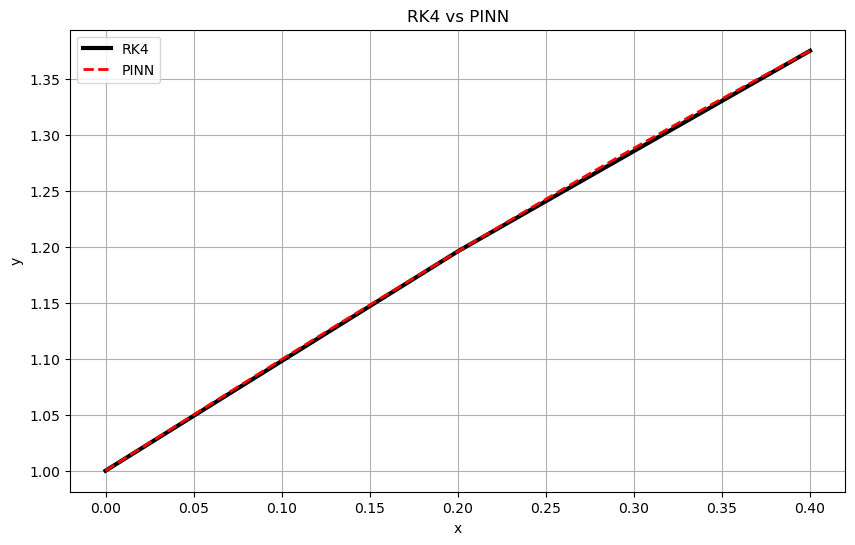

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# =============================
# 1. RK4 Method
# =============================
def f(x, y):
    return (y**2 - x**2) / (y**2 + x**2)

def runge_kutta(f, x0, y0, n, h):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0
    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = runge_kutta(f, 0, 1, 2, 0.2)

# ==============================
# 2. PINN
# ==============================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)
def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - ((y_pred**2 - x_colloc**2) / (y_pred**2 + x_colloc**2))
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0_pred - y0)**2)
    return loss_pde + loss_ic
optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it} Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.4, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x={xi:.1f}, RK4={yi:.6f}, PINN={pi:.6f}')

# ==============================
# 3. Plot
# ==============================
x_pinn_plot = torch.linspace(0, 0.4, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Exmple 10.17
Apply the Runge-Kutta method to find the approximate value of $y$ for $x = 0.2$, in steps of 0.1, if $dy/dx = x + y^2, y = 1$ where $x = 0$.

Adam Iter 0, Losss 1.218e+00
Adam Iter 1000, Losss 9.841e-06
Adam Iter 2000, Losss 7.527e-06
Adam Iter 3000, Losss 8.292e-04
Adam Iter 4000, Losss 2.004e-03
Adam Iter 5000, Losss 8.885e-05
Adam Iter 6000, Losss 6.904e-06
Adam Iter 7000, Losss 2.517e-05
Adam Iter 8000, Losss 6.489e-06
Adam Iter 9000, Losss 6.120e-06
x=0.0, RK4=1.000000, PINN=0.999973
x=0.1, RK4=1.116492, PINN=1.116388
x=0.2, RK4=1.273563, PINN=1.273519


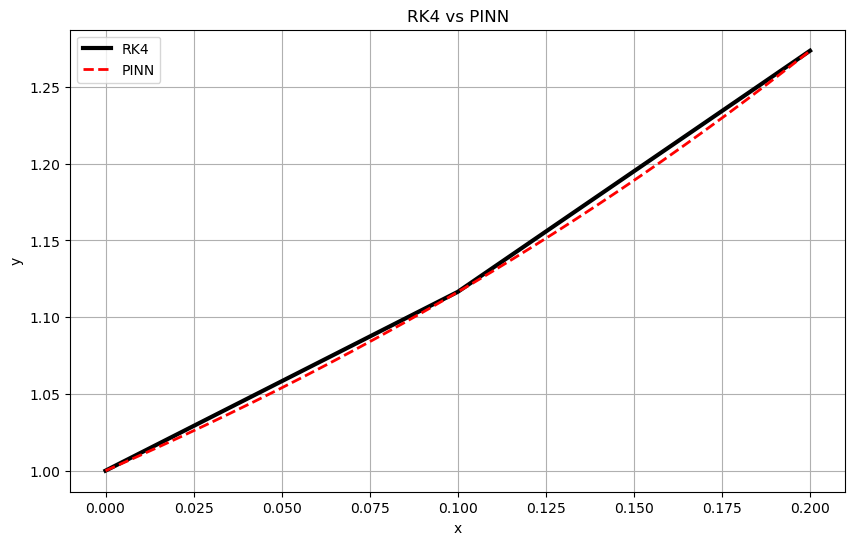

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# =============================
# 1. RK4 Method
# =============================
def f(x, y):
    return x + y**2

def runge_kutta(f, x0, y0, n, h):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0
    
    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2 , y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = runge_kutta(f, 0, 1, 2, 0.1)

# ===================================
# 2. PINN
# ===================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - x_colloc - y_pred**2
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Losss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.2, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x={xi:.1f}, RK4={yi:6f}, PINN={pi:.6f}')

# ===================================
# 3. PLOT
# ===================================
x_plot = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_plot = model(x_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_plot, y_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Example 10.18
Using the Runge-Kutta method of fourth order, solve for $y$ at $x = 1.2, 1.4$ from $dy/dx = (2xy + e^x) / (x^2 + xe^x)$ given $y(1) = 0$.

Adam Iter 0, Loss 4.609e-01
Adam Iter 1000, Loss 2.236e-05
Adam Iter 2000, Loss 1.810e-05
Adam Iter 3000, Loss 1.217e-05
Adam Iter 4000, Loss 5.910e-06
Adam Iter 5000, Loss 2.195e-06
Adam Iter 6000, Loss 5.804e-06
Adam Iter 7000, Loss 1.825e-07
Adam Iter 8000, Loss 1.016e-07
Adam Iter 9000, Loss 4.932e-08
x=1.0, RK4=0.000000, PINN=0.000000
x=1.2, RK4=0.140213, PINN=0.140219
x=1.4, RK4=0.270501, PINN=0.270499


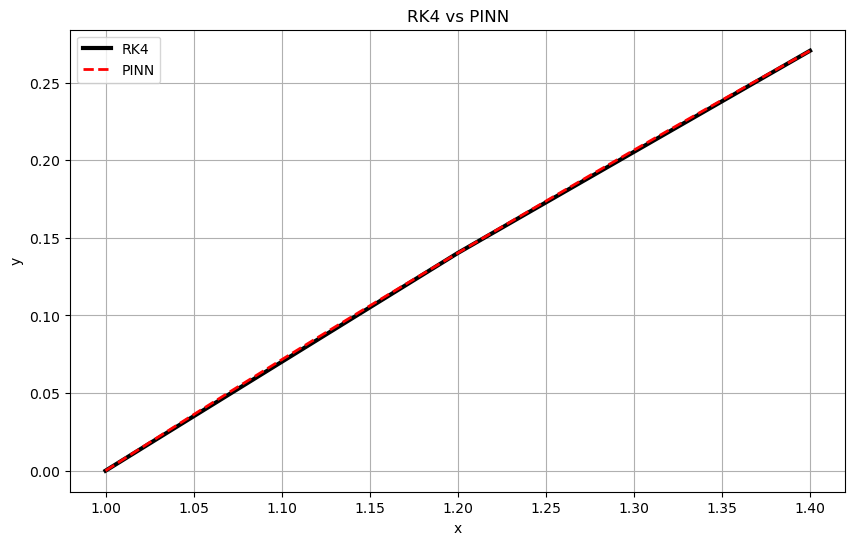

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ============================
# 1. RK4 Method
# ============================
def f(x, y):
    return (2*x*y + np.exp(x)) / (x**2 + x*np.exp(x))

def runge_kutta(f, x0, y0, n, h):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = runge_kutta(f, 1, 0, 2, 0.2)

# =============================
# 2. PINN
# =============================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(1, 1.4, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([1.0], dtype=torch.float32, device=device)
y0 = torch.tensor([0.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - (2*x_colloc*y_pred + torch.exp(x_colloc)) / (x_colloc**2 + x_colloc*torch.exp(x_colloc))
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(1, 1.4, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x={xi:.1f}, RK4={yi:.6f}, PINN={pi:.6f}')

# ==============================
# 3. Plot
# ==============================
x_plot = torch.linspace(1, 1.4, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_plot = model(x_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_plot, y_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.3.1
Use Runge’s method to approximate $y$ when $x = 1.1$, given that $y = 1.2$ when $x = 1$ and $dy/dx = 3x + y^2$.

Adam Iter 0, Loss 1.200e+01
Adam Iter 1000, Loss 4.360e-04
Adam Iter 2000, Loss 5.851e-05
Adam Iter 3000, Loss 4.089e-06
Adam Iter 4000, Loss 1.379e-06
Adam Iter 5000, Loss 9.617e-07
Adam Iter 6000, Loss 7.286e-07
Adam Iter 7000, Loss 5.528e-07
Adam Iter 8000, Loss 5.838e-07
Adam Iter 9000, Loss 2.268e-06
x=1.0, RK4=1.200000, PINN=1.200025
x=1.1, RK4=1.727072, PINN=1.727096


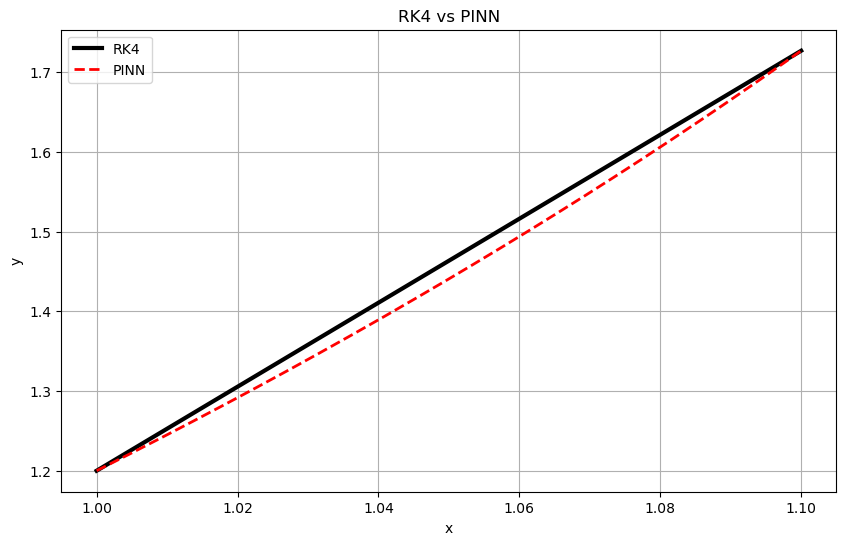

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# =============================
# 1. RK4 Method
# =============================
def f(x, y):
    return 3*x + y**2

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 1, 1.2, 0.1, 1)

# =============================
# 2. PINN
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(1, 1.1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([1.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.2], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - 3*x_colloc - y_pred**2
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(1, 1.1, 2, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x={xi:.1f}, RK4={yi:.6f}, PINN={pi:.6f}')

# =============================
# 3. Plot
# =============================
x_plot = torch.linspace(1, 1.1, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_plot = model(x_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_plot, y_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.3.2
Using the Runge-Kutta method of order 4, find $y(0.2)$ given that $\frac{dy}{dx} = 3x + y^2$, $y(0) = 1$ taking $h = 0.1$

Adam Iter 0, Loss 6.906e-01
Adam Iter 1000, Loss 1.209e-05
Adam Iter 2000, Loss 1.116e-05
Adam Iter 3000, Loss 1.092e-05
Adam Iter 4000, Loss 1.074e-05
Adam Iter 5000, Loss 1.276e-05
Adam Iter 6000, Loss 1.068e-05
Adam Iter 7000, Loss 1.032e-05
Adam Iter 8000, Loss 9.696e-06
Adam Iter 9000, Loss 9.214e-06
x=0.0, RK4=1.000000, PINN=0.999974
x=0.1, RK4=1.127259, PINN=1.127137
x=0.2, RK4=1.320830, PINN=1.320787


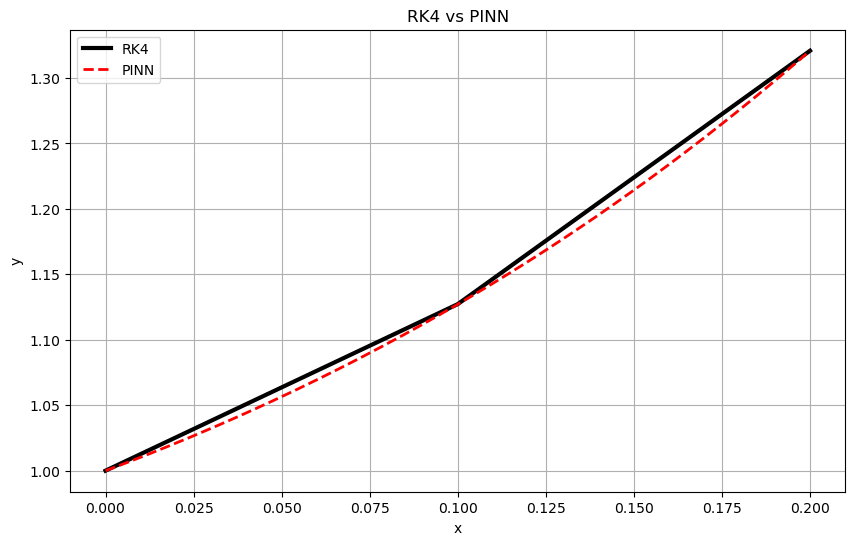

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# =============================
# 1. RK4 Method
# =============================
def f(x, y):
    return 3*x + y**2

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.1, 2)

# =============================
# 2. PINN
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - 3*x_colloc - y_pred**2
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.2, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x={xi:.1f}, RK4={yi:.6f}, PINN={pi:.6f}')

# =============================
# 3. Plot
# =============================
x_plot = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_plot = model(x_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_plot, y_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.3.3
Using the Runge-Kutta method of order 4, compute $y(0.2)$ and $y(0.4)$ from $dy/dx = (x^2 + y^2)/10$, $y(0) = 1$, taking $h = 0.1$.

Adam Iter 0, Loss 9.559e-01
Adam Iter 1000, Loss 3.467e-06
Adam Iter 2000, Loss 2.743e-06
Adam Iter 3000, Loss 1.818e-06
Adam Iter 4000, Loss 8.985e-07
Adam Iter 5000, Loss 2.893e-06
Adam Iter 6000, Loss 9.279e-08
Adam Iter 7000, Loss 8.560e-07
Adam Iter 8000, Loss 3.619e-08
Adam Iter 9000, Loss 3.441e-08
x=0.0, RK4=1.000000, PINN=1.000002
x=0.1, RK4=1.010135, PINN=1.010135
x=0.2, RK4=1.020678, PINN=1.020669
x=0.3, RK4=1.031842, PINN=1.031852
x=0.4, RK4=1.043845, PINN=1.043850


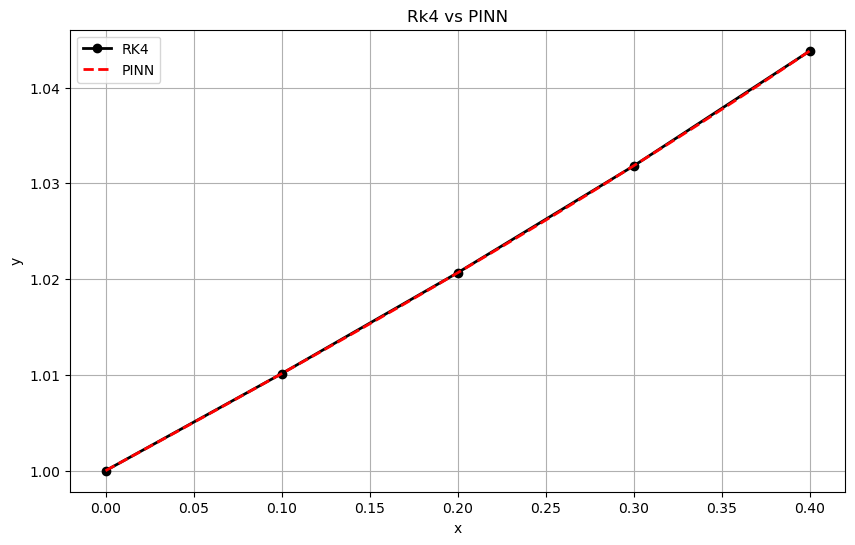

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==============================
# 1. RK4 Method
# ==============================
def f(x, y):
    return (x**2 + y**2) / 10

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0
    
    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.1, 4)

# =============================
# 2.PINN
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.4, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - (x_colloc**2 + y_pred**2) / 10
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.4, 5, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x={xi:.1f}, RK4={yi:.6f}, PINN={pi:.6f}')

# ==============================
# 3. Plot
# ==============================
x_plot = torch.linspace(0, 0.4, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_plot = model(x_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'ko-', label='RK4', linewidth=2)
plt.plot(x_plot, y_plot, 'r--', label='PINN', linewidth=2)
plt.title('Rk4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.3.4
Use the Runge-Kutta method to find $y$ when $x = 1.2$ in steps of $0.1$, given that $\frac{dy}{dx} = x^2 + y^2$ and $y(1) = 1.5$.

Adam Iter 0, Loss 3.514e+00
Adam Iter 1000, Loss 2.762e-04
Adam Iter 2000, Loss 7.270e-04
Adam Iter 3000, Loss 4.912e-05
Adam Iter 4000, Loss 1.363e-05
Adam Iter 5000, Loss 3.033e-06
Adam Iter 6000, Loss 1.089e-06
Adam Iter 7000, Loss 1.073e-06
Adam Iter 8000, Loss 2.925e-05
Adam Iter 9000, Loss 4.954e-03
x=1.0, RK4=1.500000, PINN=1.499982
x=1.1, RK4=1.895517, PINN=1.895523
x=1.2, RK4=2.504366, PINN=2.504384


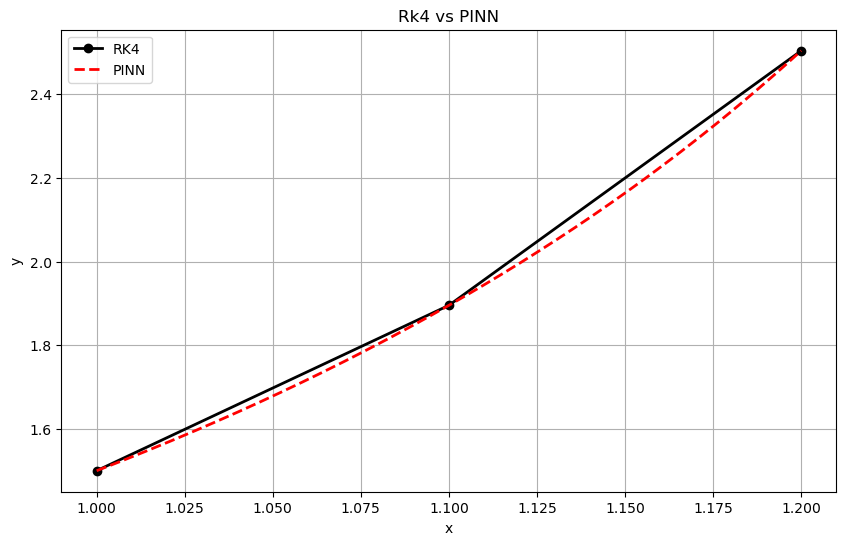

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==============================
# 1. RK4 Method
# ==============================
def f(x, y):
    return (x**2 + y**2)

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0
    
    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 1, 1.5, 0.1, 2)

# =============================
# 2.PINN
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(1, 1.2, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([1.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.5], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - (x_colloc**2 + y_pred**2)
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(1, 1.2, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x={xi:.1f}, RK4={yi:.6f}, PINN={pi:.6f}')

# ==============================
# 3. Plot
# ==============================
x_plot = torch.linspace(1, 1.2, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_plot = model(x_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'ko-', label='RK4', linewidth=2)
plt.plot(x_plot, y_plot, 'r--', label='PINN', linewidth=2)
plt.title('Rk4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.3.5
Given $\frac{dy}{dx} = x^3 + y$, $y(0) = 2$. Compute $y(0.2)$, $y(0.4)$, and $y(0.6)$ by the Runge-Kutta method of fourth order.

Adam Iter 0, Loss 4.537e+00
Adam Iter 1000, Loss 4.807e-04
Adam Iter 2000, Loss 1.378e-04
Adam Iter 3000, Loss 1.664e-05
Adam Iter 4000, Loss 1.530e-06
Adam Iter 5000, Loss 8.364e-07
Adam Iter 6000, Loss 8.838e-07
Adam Iter 7000, Loss 8.907e-07
Adam Iter 8000, Loss 2.060e-06
Adam Iter 9000, Loss 1.007e-06
x=0.0, RK4=2.000000, PINN=1.999994
x=0.2, RK4=2.443214, PINN=2.701897
x=0.4, RK4=2.990579, PINN=3.680939


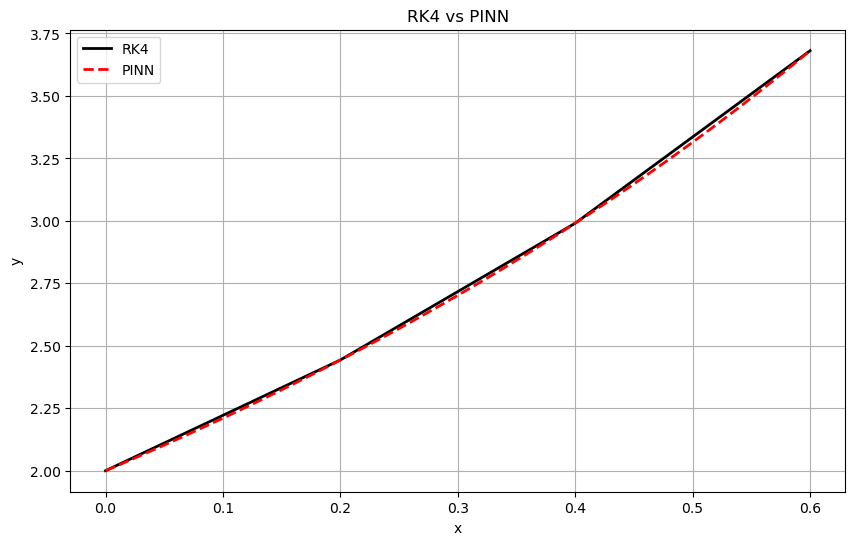

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==============================
# 1. RK4 Method
# ==============================
def f(x, y):
    return x**3 + y
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 2, 0.2, 3)

# =================================
# 2. PINN
# =================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.6, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([2.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - x_colloc**3 - y_pred
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.6, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x={xi:.1f}, RK4={yi:.6f}, PINN={pi:.6f}')

# =================================
# 3. Plot
# =================================
x_plot = torch.linspace(0, 0.6, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_plot = model(x_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=2)
plt.plot(x_plot, y_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Exercise 10.3.6
Find $y(0.1)$ and $y(0.2)$ using the Runge-Kutta fourth order formula, given that $y' = x^2 - y$ and $y(0) = 1$.

Adam Iter 0, Loss 9.840e-01
Adam Iter 1000, Loss 3.141e-06
Adam Iter 2000, Loss 1.039e-06
Adam Iter 3000, Loss 3.164e-07
Adam Iter 4000, Loss 2.740e-07
Adam Iter 5000, Loss 2.704e-07
Adam Iter 6000, Loss 2.876e-07
Adam Iter 7000, Loss 3.014e-07
Adam Iter 8000, Loss 3.164e-07
Adam Iter 9000, Loss 3.315e-07
x=0.0, Exact=1.000000, RK4= 1.000000, PINN=1.000000
x=0.1, Exact=0.905163, RK4= 0.905163, PINN=0.905143
x=0.2, Exact=0.821269, RK4= 0.821269, PINN=0.821270


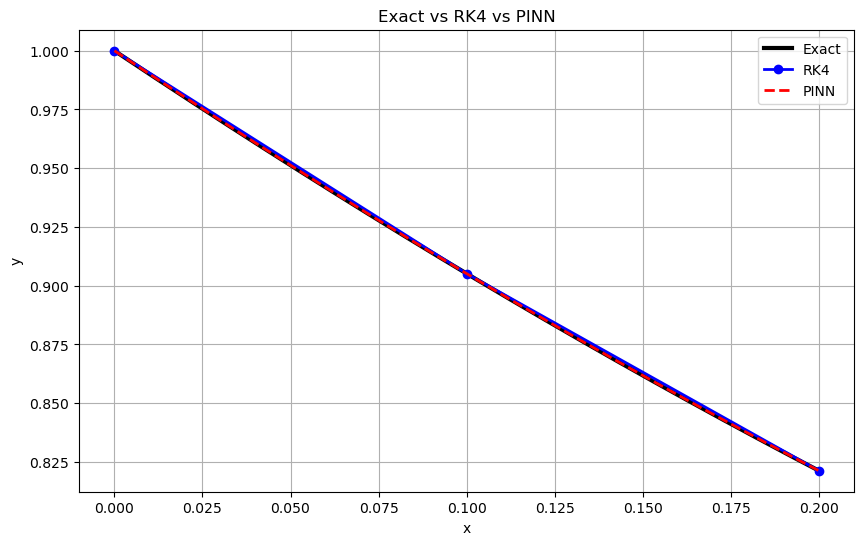

In [18]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# =============================
# 1. Exact
# =============================
x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(sp.diff(y, x, 1), x**2 - y)
exact = sp.dsolve(ode, y, ics={y.subs(x, 0): 1})
exact_numc = sp.lambdify(x, exact.rhs, 'numpy')
x_vals = np.linspace(0, 0.2, 3)

# =============================
# 2. RK4 Method
# =============================
def f(x, y):
    return x**2 - y

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.1, 2)

# ==============================
# 3. PINN
# ==============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - x_colloc**2 + y_pred
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.2, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, exact_numc(x_vals), ys, y_pinn):
    print(f'x={xi:.1f}, Exact={zi:.6f}, RK4= {yi:.6f}, PINN={pi:.6f}')

# ==============================
# 4. Plot
# ==============================
x_plot = np.linspace(0, 0.2, 200)
y_plot = exact_numc(x_plot)
x_pinn_plot = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_plot, 'k-', label='Exact', linewidth=3)
plt.plot(xs, ys, 'bo-', label='RK4', linewidth=2)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('Exact vs RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.3.7
Using fourth order Runge-Kutta method, solve the following equation, taking each step of $h = 0.1$, given $y(0) = 3$, $\frac{dy}{dx} = \frac{4x}{y} - xy$. Calculate $y$ for $x = 0.1$ and $0.2$.

Adam Iter 0, Loss 1.138e+01
Adam Iter 1000, Loss 2.931e-04
Adam Iter 2000, Loss 3.105e-06
Adam Iter 3000, Loss 1.944e-06
Adam Iter 4000, Loss 7.329e-07
Adam Iter 5000, Loss 1.162e-07
Adam Iter 6000, Loss 2.168e-08
Adam Iter 7000, Loss 1.880e-08
Adam Iter 8000, Loss 1.812e-08
Adam Iter 9000, Loss 1.720e-08
x =0.0, RK4=3.000000, PINN=2.999996
x =0.1, RK4=2.991697, PINN=2.991691
x =0.2, RK4=2.967145, PINN=2.967141


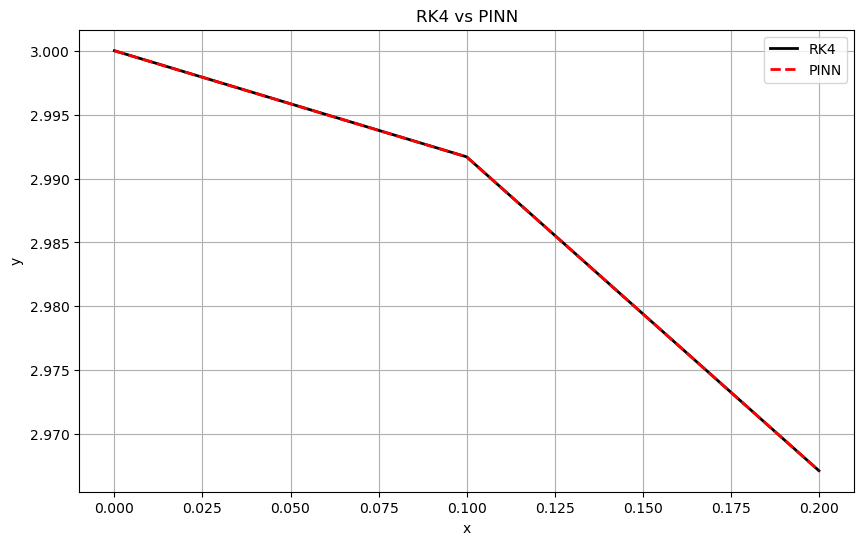

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# =============================
# 1. RK4 Method
# =============================
def f(x, y):
    return (4*x/y) - x*y

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 3, 0.1, 2)

# =============================
# 2. PINN
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
            )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([3.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - (4*x_colloc/y_pred) + x_colloc*y_pred
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic
optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.2, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, pi in zip(xs, ys, y_pinn):
    print(f'x ={xi:.1f}, RK4={yi:.6f}, PINN={pi:.6f}')
# =============================
# 3. Plot
# =============================
x_pinn_plot = torch.linspace(0, 0.2, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=2)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.3.8
Find by the Runge-Kutta method an approximate value of $y$ for $x = 0.6$, given that $y = 0.41$ when $x = 0.4$ and $\frac{dy}{dx} = \sqrt{x + y}$.

Adam Iter 0, Loss 6.349e-01
Adam Iter 1000, Loss 7.870e-08
Adam Iter 2000, Loss 7.865e-08
Adam Iter 3000, Loss 1.273e-07
Adam Iter 4000, Loss 7.945e-08
Adam Iter 5000, Loss 9.961e-08
Adam Iter 6000, Loss 8.467e-08
Adam Iter 7000, Loss 1.745e-07
Adam Iter 8000, Loss 9.241e-08
Adam Iter 9000, Loss 9.395e-08
x=0.4, Scipy=0.410000, RK4=0.410000, PINN=0.409999
x=0.5, Scipy=0.505177, RK4=0.505176, PINN=0.505165
x=0.6, Scipy=0.610351, RK4=0.610350, PINN=0.610350


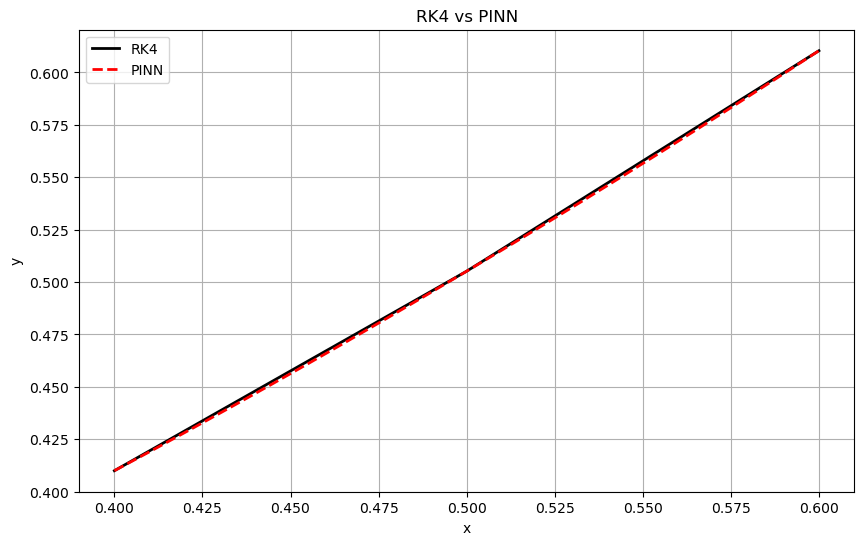

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

# ===============================
# 1. Scipy
# ===============================
def f(x, y):
    return np.sqrt( x + y)

x_vals = np.linspace(0.4, 0.6, 3)

scipy = integrate.solve_ivp(f, (0.4, 0.6), [0.41], method='RK45', t_eval=x_vals)

# ===============================
# 2. RK4 Method
# ===============================
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0.4, 0.41, 0.1, 2)
# ==============================
# 3. PINN
# ==============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0.4, 0.6, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.4], dtype=torch.float32, device=device)
y0 = torch.tensor([0.41], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - torch.sqrt(x_colloc + y_pred)
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0.4, 0.6, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, scipy.y[0], ys, y_pinn):
    print(f'x={xi:.1f}, Scipy={yi:.6f}, RK4={zi:.6f}, PINN={pi:.6f}')
# ==============================
# 4. Plot
# ==============================
x_pinn_plot = torch.linspace(0.4, 0.6, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=2)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.3.9
Using the Runge-Kutta method of order 4, find $y(0.2)$ for the equation $dy/dx = (y - x) / (y + x)$, $y(0) = 1$. Take $h = 0.2$.

Adam Iter 0, Loss 2.408e+03
Adam Iter 1000, Loss 7.596e-01
Adam Iter 2000, Loss 7.593e-01
Adam Iter 3000, Loss 7.587e-01
Adam Iter 4000, Loss 7.575e-01
Adam Iter 5000, Loss 7.555e-01
Adam Iter 6000, Loss 7.522e-01
Adam Iter 7000, Loss 7.468e-01
Adam Iter 8000, Loss 7.380e-01
Adam Iter 9000, Loss 7.236e-01
x=0.0, Scipy=1.000000, RK4=1.000000, PINN=1.000007
x=0.2, Scipy=1.167842, RK4=1.167862, PINN=1.167849


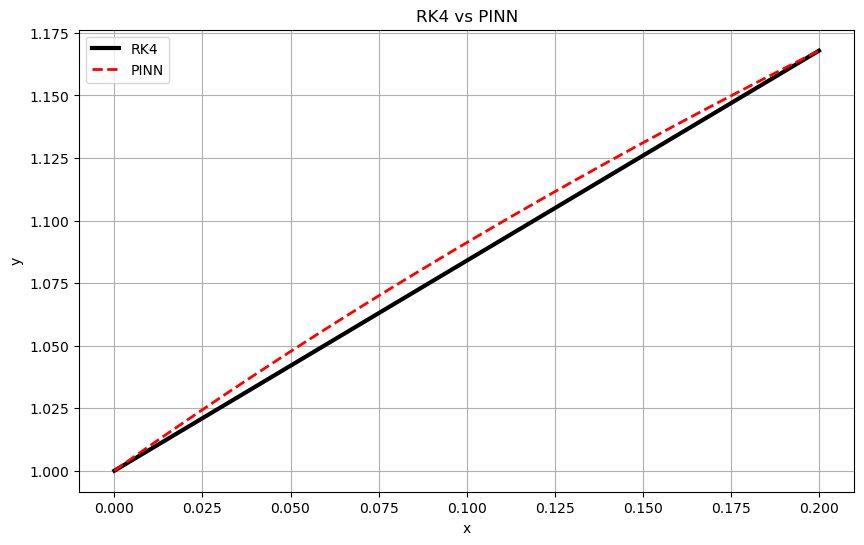

In [15]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

# ==============================
# 1. Scipy
# ==============================
def f(x, y):
    return (y - x) / (y + x)

x_vals = np.linspace(0, 0.2, 2)

scipy = integrate.solve_ivp(f, (0, 0.2), [1.0], method='RK45', t_eval=x_vals)

# ==============================
# 2. RK4 Method
# ==============================
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.2, 1)
# ================================
# 3. PINN
# ================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - (y_pred - x_colloc) / (y_pred + x_colloc)
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.2, 2, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, scipy.y[0], ys, y_pinn):
    print(f'x={xi:.1f}, Scipy={yi:.6f}, RK4={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_pinn_plot = torch.linspace(0, 0.2, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Exercise 10.3.10
Using fourth order Runge-Kutta method, integrate $y' = -2x^3 + 12x^2 - 20x + 8.5$ using a step size of $0.5$ and initial condition of $y = 1$ at $x = 0$.

Adam Iter 0, Loss 1.348e+01
Adam Iter 1000, Loss 1.063e-03
Adam Iter 2000, Loss 8.558e-05
Adam Iter 3000, Loss 5.341e-05
Adam Iter 4000, Loss 3.887e-05
Adam Iter 5000, Loss 2.465e-05
Adam Iter 6000, Loss 1.188e-05
Adam Iter 7000, Loss 4.287e-06
Adam Iter 8000, Loss 1.403e-06
Adam Iter 9000, Loss 9.037e-07
x=0.0, Scipy=1.000000, RK4=1.000000, PINN=1.000018
x=0.5, Scipy=3.218750, RK4=3.218750, PINN=3.218774
x=1.0, Scipy=3.000000, RK4=3.000000, PINN=3.000046


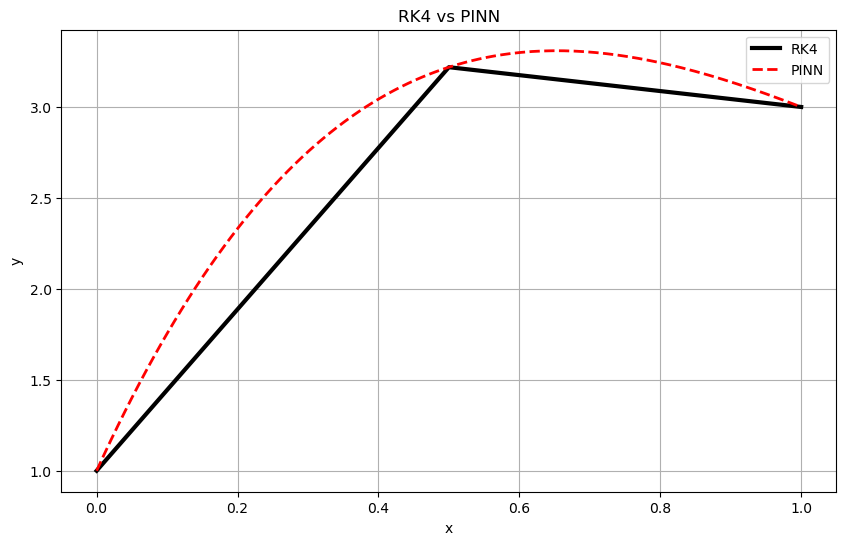

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

# ===============================
# 1. Scipy
# ===============================
def f(x, y):
    return -2*x**3 + 12*x**2 -20*x + 8.5

x_vals = np.linspace(0, 1, 3)

scipy = integrate.solve_ivp(f, (0, 1), [1.0], method='RK45', t_eval=x_vals)
# ===============================
# 2. RK4 Method
# ===============================
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.5, 2)
# ================================
# 3. PINN
# ================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy + 2*x_colloc**3 - 12*x_colloc**2 + 20*x_colloc - 8.5
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic
optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 1, 3, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, scipy.y[0], ys, y_pinn):
    print(f'x={xi:.1f}, Scipy={yi:.6f}, RK4={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_pinn_plot = torch.linspace(0, 1, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Exercise 10.3.11
Using the fourth order Runge-Kutta method, find $y$ at $x = 0.1$ given that $dy/dx = 3e^x + 2y$, $y(0) = 0$ and $h = 0.1$.

Adam Iter 0, Loss 6.408e+00
Adam Iter 1000, Loss 1.062e-05
Adam Iter 2000, Loss 3.987e-06
Adam Iter 3000, Loss 1.467e-06
Adam Iter 4000, Loss 2.051e-06
Adam Iter 5000, Loss 5.236e-07
Adam Iter 6000, Loss 4.825e-07
Adam Iter 7000, Loss 5.706e-07
Adam Iter 8000, Loss 5.126e-07
Adam Iter 9000, Loss 5.417e-07
x=0.0, Scipy=0.000000, RK4=0.000000, PINN=-0.000006
x=0.1, Scipy=0.348696, RK4=0.348689, PINN=0.348688


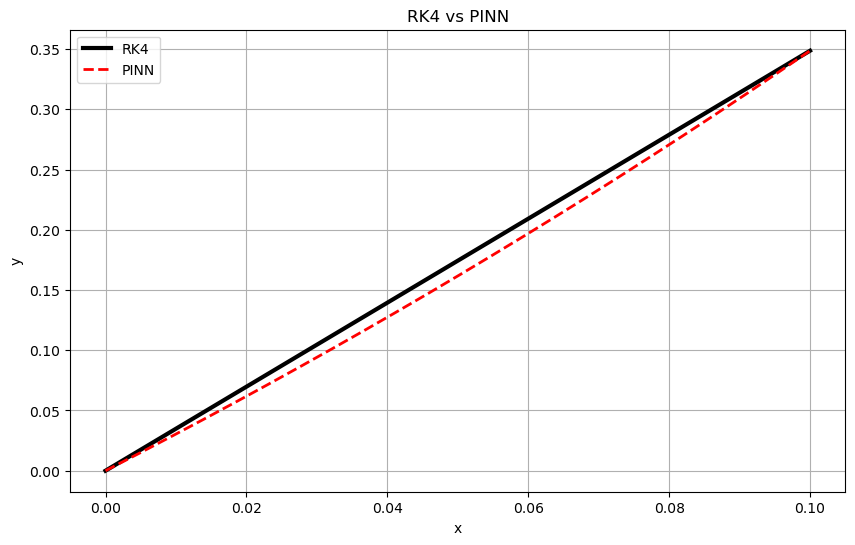

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

# ===============================
# 1. Scipy
# ===============================
def f(x, y):
    return 3*np.exp(x) + 2*y

x_vals = np.linspace(0, 0.1, 2)

scipy = integrate.solve_ivp(f, (0, 0.1), [0], method='RK45', t_eval=x_vals)
# ===============================
# 2. RK4 Method
# ===============================
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 0, 0.1, 1)
# ===============================
# 3. PINN
# ===============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.1, 400, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([0.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - 3*torch.exp(x_colloc) - 2*y_pred
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.1, 2, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, scipy.y[0], ys, y_pinn):
    print(f'x={xi:.1f}, Scipy={yi:.6f}, RK4={zi:.6f}, PINN={pi:.6f}')
# ===============================
# 4. Plot
# ===============================
x_pinn_plot = torch.linspace(0, 0.1, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Exercise 10.3.12
Given that $dy/dx = y^2 - 2x / y^2 + x$ and $y = 1$ at $x = 0$, find $y$ for $x = 0.1, 0.2, 0.3, 0.4$, and $0.5$.

Adam Iter 0, Loss 4.776e+00
Adam Iter 1000, Loss 2.844e-04
Adam Iter 2000, Loss 5.403e-05
Adam Iter 3000, Loss 1.128e-05
Adam Iter 4000, Loss 7.217e-06
Adam Iter 5000, Loss 4.094e-06
Adam Iter 6000, Loss 1.755e-06
Adam Iter 7000, Loss 4.957e-07
Adam Iter 8000, Loss 1.264e-07
Adam Iter 9000, Loss 8.664e-08
x=0.0, Scipy=1.000000, RK4=1.000000, PINN=1.000004
x=0.1, Scipy=1.087380, RK4=1.087369, PINN=1.087384
x=0.2, Scipy=1.155861, RK4=1.155715, PINN=1.155711
x=0.3, Scipy=1.210520, RK4=1.210461, PINN=1.210466
x=0.4, Scipy=1.254415, RK4=1.254436, PINN=1.254435
x=0.5, Scipy=1.289296, RK4=1.289269, PINN=1.289269


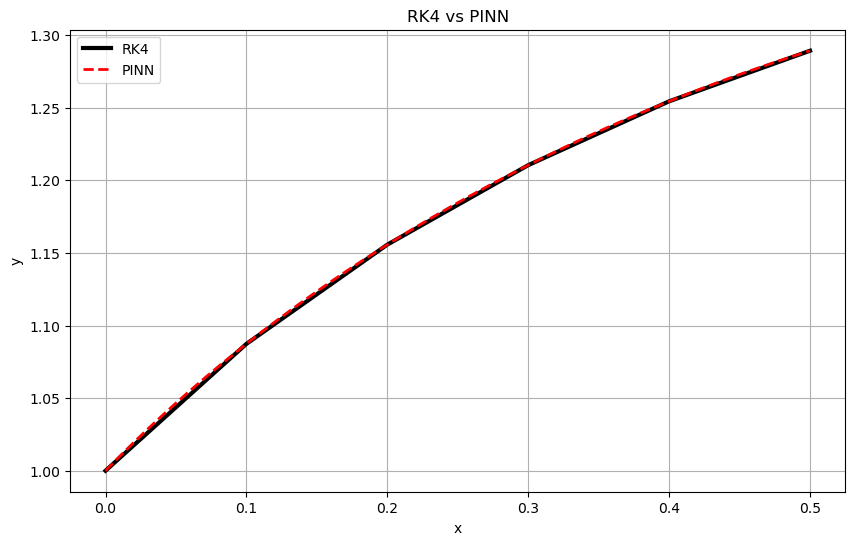

In [39]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

# ==============================
# 1. Scipy
# ==============================
def f(x, y):
    return (y**2 - 2*x) / (y**2 + x)

x_vals = np.linspace(0, 0.5, 6)

scipy = integrate.solve_ivp(f, (0, 0.5), [1], method='RK45', t_eval=x_vals)
# ==============================
# 2. RK4 Method
# ==============================
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.1, 5)
# =================================
# 3. PINN
# =================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 0.5, 300, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - (y_pred**2 - 2*x_colloc) / (y_pred**2 + x_colloc)
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic
optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.5, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, scipy.y[0], ys, y_pinn):
    print(f'x={xi:.1f}, Scipy={yi:.6f}, RK4={zi:.6f}, PINN={pi:.6f}')
# =================================
# 4. Plot
# =================================
x_pinn_plot = torch.linspace(0, 0.5, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='RK4', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('RK4 vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()